In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os

****Table Head****

In [2]:
df = pd.read_csv('epilepsy-detection-datasets/eeg_data.csv')
print(df.shape)
df.head()

(2216, 668)


,FP1_power_delta,FP1_power_theta,FP1_power_alpha,FP1_power_beta,FP1_power_gamma,FP2_power_delta,FP2_power_theta,FP2_power_alpha,FP2_power_beta,FP2_power_gamma,...,T5_STD_D4,T5_STD_D5,T5_STD_D6,T6_STD_D1,T6_STD_D2,T6_STD_D3,T6_STD_D4,T6_STD_D5,T6_STD_D6,epileptic_
0,15.980332,8.633358,3.092433,0.846559,0.372832,17.581626,9.937238,3.485713,0.945396,0.428797,...,31.427918,29.699413,32.013546,3.583559,12.529528,45.831132,61.890813,34.783454,33.245906,1
1,223.267803,41.573241,13.043525,6.463381,6.168712,298.274432,50.013025,14.411482,6.659230,4.942250,...,24.822720,47.185918,93.619195,14.158489,15.217886,30.927407,77.324322,153.442359,213.780950,1
2,158.673907,31.788608,9.956198,3.736977,2.926979,232.762741,39.332981,10.956081,3.478036,2.153082,...,21.708222,47.412375,85.729645,9.493639,11.824569,24.555772,59.229187,112.406306,171.618208,1
3,29.767326,3.875543,1.553127,0.438266,0.140495,45.206547,5.173542,2.028637,0.528962,0.161283,...,26.319506,39.628894,51.473202,1.872515,5.392639,17.296780,35.824586,44.892899,79.613460,1
4,33.821075,3.635210,1.347280,0.313205,0.080396,55.670043,4.925017,1.783729,0.394463,0.102254,...,26.111048,39.177537,52.925676,1.408291,4.556997,12.733549,25.676801,44.406617,94.770581,1


We have a dataset that consists of 2216 rows, each presenting an EEG examination of multiple different channels on a person's scalp with different frequency bands.

The table consists of 668 columns - 253 columns presenting different frequencies recorded on the EEG checkup on various places on the person's scalp.

The remaining columns present recordings of LSWT - local sleep-wake transition bands across different times, and statistical values from a specific checkup, such as mean and std of a frequency recorded on a specific part of the scalp and at different times (D1,D2,etc...).

At the end of the table, we see the Target - whether the person who went through the examination is epileptic or not (1,0)

In this notebook, I will try to characterize the main features of an EEG checkup that may indicate whether or not a person has Epilepsy and create multiple predictive models that when given the selected features would be able to adequately predict Epilepsy.

**EDA**

In [3]:
### Num of duplicate rows - neglectable
df.duplicated().sum()

8

In [4]:
df.isnull().sum().value_counts()
### No NaN Values 

0    668
Name: count, dtype: int64

At first glance we see no missing values, however, a quick view at the features table shows a lot of 0s in columns that otherwise have decimal readings of EEG frequencies. 

I assume 0s are the missing values for those columns.

I will examine these columns as they may be features that should be excluded when training predictive models

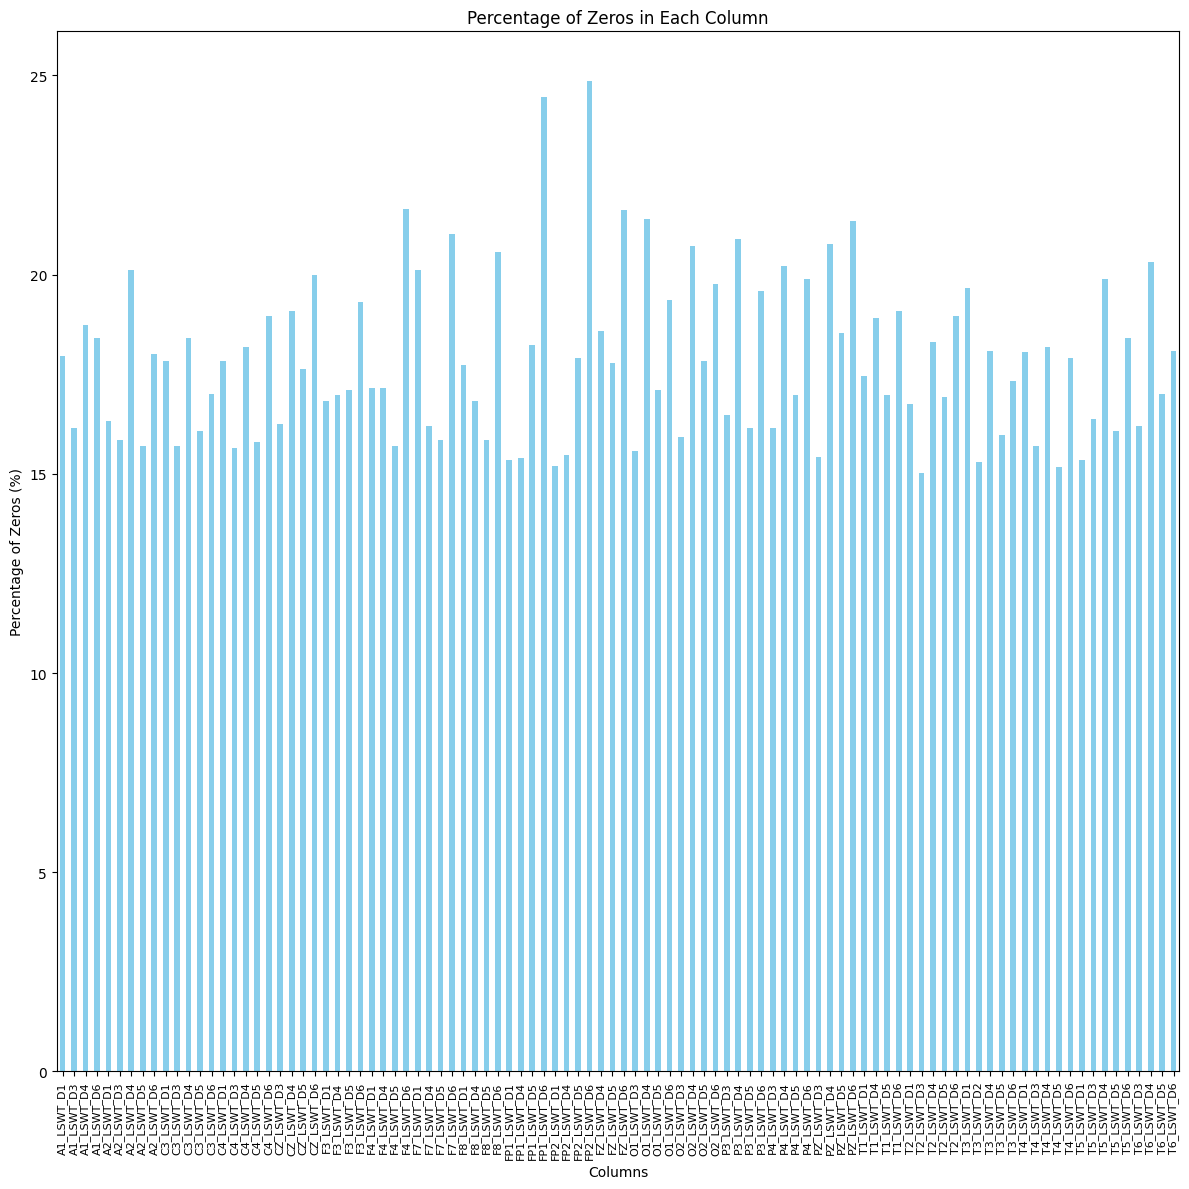

A1_LSWT_D1    17.960289
A1_LSWT_D3    16.155235
A1_LSWT_D4    18.727437
A1_LSWT_D6    18.411552
A2_LSWT_D1    16.335740
                ...    
T5_LSWT_D6    18.411552
T6_LSWT_D3    16.200361
T6_LSWT_D4    20.306859
T6_LSWT_D5    17.012635
T6_LSWT_D6    18.095668
Length: 98, dtype: float64


In [5]:
zero_counts = (df == 0).sum()

zero_percentage = (zero_counts / len(df)) * 100

### I want to view only the features that have more than 15% of their values equal to 0

zero_percentage = zero_percentage[(zero_percentage>=15) & (zero_percentage.index != 'epileptic_')]

plt.figure(figsize=(12, 12))
zero_percentage.plot(kind='bar', color='skyblue')
plt.title('Percentage of Zeros in Each Column')
plt.xlabel('Columns')
plt.ylabel('Percentage of Zeros (%)')
plt.xticks(rotation=90, ha='center', fontsize=8)  
plt.tight_layout()  
plt.show()
print(zero_percentage)

#Saving the columns' names for future use
columns_with_zeros = zero_percentage.index.to_list()

These features have more than 15% percent of their values equal to zero which I presume is equivalent to Nulls. 
We can see from the plot all values are of LSWT across different parts of the brain and times.

LSWT - Local Sleep-Wake Transition in another scale being examined in EEGs. Across 98 different scales, it seems to have missing values which, I assume, indicates their redundancy. 

However, I've set a threshold of 15% or more values missing as a condition if feature values should be dropped or not therefore I am going to drop the LSWT readings before training models.

In [6]:
df.dtypes.value_counts()
### 667 features of frequencies , Target is Binary (1,0)

float64    667
int64        1
Name: count, dtype: int64

In [7]:
non_epileptic = df[df['epileptic_'] == 0]
epileptic = df[df['epileptic_'] == 1]
print("Targets : ",'\n' ,"Num of Epileptic : ", len(epileptic),'\n', "Num of Non Epileptic : ", len(non_epileptic) )

Targets :  
 Num of Epileptic :  1020 
 Num of Non Epileptic :  1196


Using Point-Biserial Correlation Coefficient to try and evaluate the most impactful features on the Target

The Point-Biserial Correlation is a special case of the Pearson correlation coefficient used when one variable is continuous, and the other is binary (dichotomous). It measures the strength and direction of the association between the continuous variable and the binary target.

The values of the the correlation travel between [-1,1] where values closer to 1 indicate the variable's correlation to value 1 (yes) of the target and those closer to -1 indicate the correlation of the variable to the value 0 (no) of the target

In [8]:
import scipy.stats as stats
import matplotlib.pyplot as plt
correlations = []

for col in df.columns:
    if col != 'epileptic_':
        r_pb, p_value = stats.pointbiserialr(df[col], df['epileptic_'])
        correlations.append((col, r_pb, p_value))

correlation_df = pd.DataFrame(correlations, columns=['Feature', 'Point-Biserial Correlation', 'p-value'])
correlation_df['Absolute Correlation'] = correlation_df['Point-Biserial Correlation'].abs()
correlation_df = correlation_df.sort_values(by='Absolute Correlation', ascending=False)
correlation_df = correlation_df.drop(columns='Absolute Correlation')
# Display the top 15 most correlated features

print(correlation_df.head(15))



            Feature  Point-Biserial Correlation       p-value
535       A2_STD_D1                    0.122089  8.136264e-09
397  A2_Mean_Abs_D1                    0.119720  1.577606e-08
131      C3_LSWT_D5                   -0.107037  4.408898e-07
400  A2_Mean_Abs_D4                    0.102783  1.243566e-06
391  A1_Mean_Abs_D1                    0.102365  1.374022e-06
529       A1_STD_D1                    0.101737  1.595029e-06
536       A2_STD_D2                    0.100601  2.084147e-06
221      T1_LSWT_D5                   -0.094140  9.040377e-06
401  A2_Mean_Abs_D5                    0.093358  1.072945e-05
202      P3_LSWT_D4                   -0.093231  1.103159e-05
121      A2_LSWT_D1                    0.089965  2.222728e-05
399  A2_Mean_Abs_D3                    0.089890  2.258326e-05
402  A2_Mean_Abs_D6                    0.089849  2.277587e-05
398  A2_Mean_Abs_D2                    0.087966  3.373700e-05
161      F7_LSWT_D5                   -0.085460  5.623246e-05


These are the 15 most correlated features in Absolute Value - I wanted to get these features in order to visualize the regions on the head that significant EEG readings impact mostly on the existence of Epilepsy.

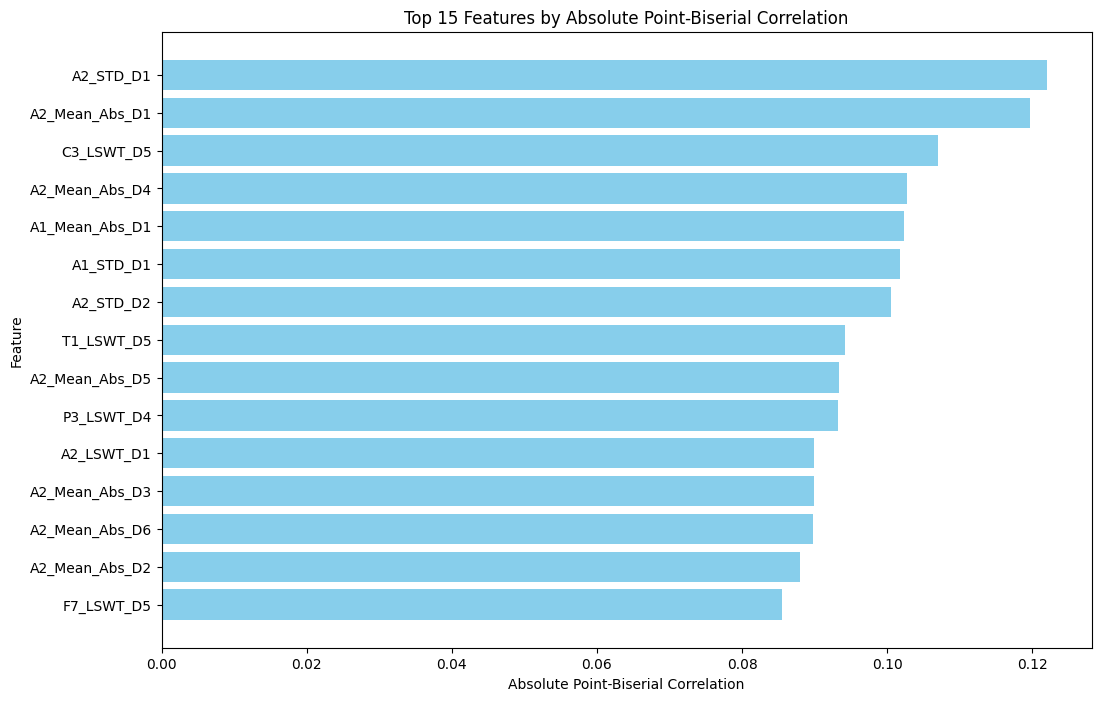

In [9]:
plt.figure(figsize=(12, 8))
plt.barh(correlation_df['Feature'].head(15),abs(correlation_df['Point-Biserial Correlation']).head(15),color = 'skyblue')
plt.xlabel('Absolute Point-Biserial Correlation')
plt.ylabel('Feature')
plt.title('Top 15 Features by Absolute Point-Biserial Correlation')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest values on top
plt.show()

As mentioned before each of the columns' names represent an ingredient of the EEG examination.

* The first part of a column's string represents the location of the electrode that was placed on the patient's head - We can clearly see that from our dataset A2 readings are highly correlated with the target - *A2 is the region of the right ear on the head*

* The second part of the string (separated by "_") represents The power of the EEG signal in the specified frequency band, reflecting the amplitude of the waves in that band. Or a statistical measure of a certain electrode placement (Mean, Std, LSWT).

* The third part (when exists) represents a hierarchical timeline as D1 comes before D2 and D3 (I assume it means different statistical measures gathered on the same patient across different days but this is not confirmed in Kaggle)




***Head Regions Visualization***

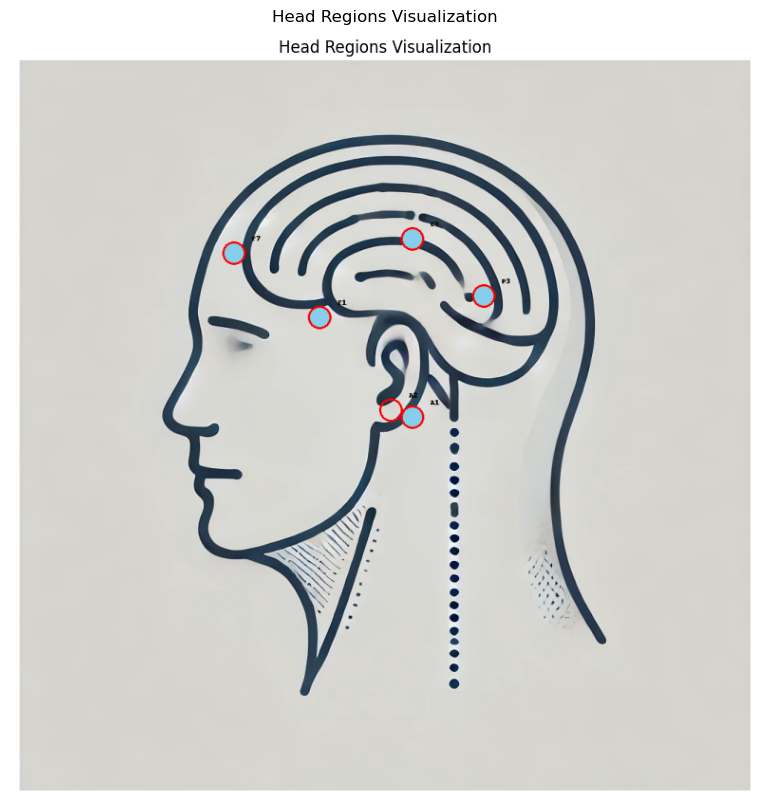

In [4]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

img = Image.open('eeg-head-image/A simple clean and clear illustration of a human head in profile with a focus on the left side. The illustration should include an outline of the h.webp.png')  
draw = ImageDraw.Draw(img)
font = ImageFont.load_default()
points = {
    "A1": (550, 500),  # Left earlobe
    "A2": (520, 490),  # Right earlobe
    "C3": (550, 250),  # Left side, midway between ear and top of head
    "T1": (420, 360),  # Left temple
    "P3": (650, 330),  # Left parietal bone
    "F7": (300, 270),  # Left forehead near hairline
}

point_radius = 16  
outline_color = 'red'
fill_color = 'skyblue'
for label, (x, y) in points.items():
    if label == "A2":
        draw.ellipse((x-point_radius, y-point_radius, x+point_radius, y+point_radius), outline=outline_color, width=3)
    else:
        draw.ellipse((x-point_radius, y-point_radius, x+point_radius, y+point_radius), fill=fill_color, outline=outline_color, width=3)
    draw.text((x + point_radius + 10, y - point_radius - 10), label, fill="black", font=font)


img.save("eeg-head-image/eeg_head_diagram_with_larger_points.png")
img = Image.open('eeg-head-image/A simple clean and clear illustration of a human head in profile with a focus on the left side. The illustration should include an outline of the h.webp.png')  

plt.figure(figsize=(10, 10))
plt.title("Head Regions Visualization")
plt.imshow(img)
plt.axis('off') 
plt.show()

Siginifical entries in these locations may indicate exsitence of Epilepsy as these are the locations that were found most correlated with the target.

**Checking Data Correlation**


In [13]:
# corr = df.copy()
# corr.drop(columns = 'epileptic_')

# Compute the correlation matrix
corr_matrix = df.drop(columns='epileptic_').corr().abs()  # Use absolute values for correlation

# Find column pairs with correlation greater than 0.9
high_corr_pairs = []

# Loop through the correlation matrix to find highly correlated pairs
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if corr_matrix.iloc[i, j] > 0.99:  # Only consider correlations above 0.9
            colname1 = corr_matrix.columns[i]
            colname2 = corr_matrix.columns[j]
            high_corr_pairs.append((colname1, colname2))

# Print the pairs of highly correlated columns
print("Columns with correlation > 0.9:")
for pair in high_corr_pairs:
    print(pair)

Columns with correlation > 0.9:
('C4_power_gamma', 'C3_power_gamma')
('P3_power_theta', 'C4_power_theta')
('P3_power_alpha', 'C4_power_alpha')
('P4_power_theta', 'C4_power_theta')
('P4_power_beta', 'C4_power_beta')
('O1_power_theta', 'C3_power_theta')
('O2_power_theta', 'P3_power_theta')
('O2_power_alpha', 'P3_power_alpha')
('O2_power_beta', 'P3_power_beta')
('O2_power_gamma', 'C3_power_gamma')
('O2_power_gamma', 'O1_power_gamma')
('T3_power_theta', 'P3_power_theta')
('T3_power_beta', 'O2_power_beta')
('T3_power_gamma', 'O1_power_gamma')
('T5_power_theta', 'P3_power_theta')
('T5_power_theta', 'O2_power_theta')
('T5_power_theta', 'T3_power_theta')
('T5_power_alpha', 'T3_power_alpha')
('T5_power_beta', 'P3_power_beta')
('T5_power_beta', 'O2_power_beta')
('T5_power_beta', 'T3_power_beta')
('T5_power_gamma', 'O1_power_gamma')
('T5_power_gamma', 'T3_power_gamma')
('T6_power_alpha', 'FP2_power_alpha')
('T6_power_beta', 'FP2_power_beta')
('T6_power_gamma', 'FP1_power_gamma')
('FZ_power_theta'

As can be seen, many features are highly correlated with others in the features table. 

I assume a high correlation between features means that some should be dropped before training predictive models.

**Data Prepration**

Since all features are numerical and the target is binary, with no missing values (except the zeros), the only preprations needed are to detect data outliers and handle them.

First we split the data to train and test in order to prevent Data Leakage when training models

In [15]:
from sklearn.model_selection import train_test_split

Random_state=123
X = df.drop(columns='epileptic_')
y = df['epileptic_']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=Random_state)

Number of Dupilcates in each set

In [17]:
print(X_train.duplicated().sum())
print(X_test.duplicated().sum())

30
1


Dropping the columns with more than 15% 0s

In [18]:
X_train.drop(columns = columns_with_zeros, inplace= True)
X_test.drop(columns = columns_with_zeros,inplace = True)
print("Train Shape:  ",X_train.shape, '\n', "Test Shape:  ", X_test.shape )

Train Shape:   (1772, 569) 
 Test Shape:   (444, 569)


In [19]:
q1 = X_train.quantile(0.25)
q3 = X_train.quantile(0.75)

IQR = q3 - q1

outliers = (X_train < (q1 - 2.5 * IQR)) | (X_train > (q3 + 2.5 * IQR))
outliers_test = (X_test < (q1 - 2.5 * IQR)) | (X_test > (q3 + 2.5 * IQR))
outliers_count = outliers.sum()
print("Total Amount of Outliers : ", outliers_count.sum(),'\n',"Precentage of Outliers out of Entire Data Points : ", str(outliers_count.sum()/(X_train.shape[0]*X_train.shape[1])*100) + "%")

outliers_count = pd.DataFrame(outliers_count)

outliers_count

Total Amount of Outliers :  103331 
 Precentage of Outliers out of Entire Data Points :  10.248366505730619%


,0
FP1_power_delta,173
FP1_power_theta,232
FP1_power_alpha,223
FP1_power_beta,194
FP1_power_gamma,188
...,...
T6_STD_D2,132
T6_STD_D3,135
T6_STD_D4,163
T6_STD_D5,189


I used the IQR of each column to identify significant outliers that may inflict bias when training the predictive model. 

I will convert the outliers in each column to the median value of that column, as Median values tend to be less biased.

Again, I used the median value for each column in the **train** data. Meaning train and test outlier values would be dealt with the appropriate train value of each column.

In [20]:
X_train = X_train.mask(outliers, X_train.median(), axis=1)
### Handling the test data the same way I handle the train because I assume no knowledge of it before modeling.
X_test = X_test.mask(outliers_test,X_train.median(),axis=1)

In [21]:
#### Making Sure Outliers were dealt with

outliers = (X_train < (q1 - 2.5 * IQR)) | (X_train > (q3 + 2.5 * IQR))

outliers_count = outliers.sum()
outliers_count

FP1_power_delta    0
FP1_power_theta    0
FP1_power_alpha    0
FP1_power_beta     0
FP1_power_gamma    0
                  ..
T6_STD_D2          0
T6_STD_D3          0
T6_STD_D4          0
T6_STD_D5          0
T6_STD_D6          0
Length: 569, dtype: int64

**Features Standardization**

In [22]:
X_train.describe()

,FP1_power_delta,FP1_power_theta,FP1_power_alpha,FP1_power_beta,FP1_power_gamma,FP2_power_delta,FP2_power_theta,FP2_power_alpha,FP2_power_beta,FP2_power_gamma,...,T5_STD_D3,T5_STD_D4,T5_STD_D5,T5_STD_D6,T6_STD_D1,T6_STD_D2,T6_STD_D3,T6_STD_D4,T6_STD_D5,T6_STD_D6
count,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,...,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000
mean,137.749849,13.965671,5.986709,3.132894,1.656786,148.146383,13.941745,6.072617,3.126631,1.639540,...,17.040325,21.336856,29.332047,48.192904,7.491884,9.909179,18.597525,25.056105,34.972262,59.723215
std,192.167401,18.102105,7.443541,4.001551,2.061623,200.295519,16.674911,7.182634,3.904423,2.045599,...,11.108759,14.691154,24.828155,41.225221,5.889290,6.153733,11.416793,17.847169,30.401855,54.153794
min,0.025945,0.012101,0.009409,0.007828,0.008412,0.026174,0.018836,0.010871,0.006120,0.006863,...,0.900698,0.950777,1.057651,1.118569,0.525890,0.846936,0.878841,0.909989,0.918962,1.115070
25%,25.029439,3.890468,1.848221,0.787700,0.378480,27.099923,4.247833,1.988331,0.844483,0.402963,...,9.852050,12.374412,14.884205,23.835592,3.502390,5.844973,11.172968,14.154016,16.619891,26.490418
50%,66.745451,8.677180,3.831232,1.791048,0.962330,70.199144,9.665363,4.132465,1.847508,0.969909,...,14.349820,18.627806,23.607998,38.722976,5.867133,8.594492,15.887545,20.995411,26.902964,44.164283
75%,136.061983,13.283679,5.934018,3.257420,1.875449,159.344123,14.813457,6.158919,3.244564,1.908385,...,19.628514,24.772379,31.244068,52.845657,9.607897,11.489409,21.890613,27.982159,39.014201,66.236424
max,875.259402,94.607352,37.132807,20.842732,11.817346,930.827596,87.309341,36.088813,21.197481,11.685969,...,62.665391,82.242369,142.843159,226.719771,30.761332,35.359155,66.960644,91.573700,157.354093,293.337475


A quick glance on the 'Describe' table shows that each column has different values in it, some have more negative values some postive etc. Since I want to train a logistic regression model as a baseline I will create a normalized copy of the train and test data

In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)

X_train_N = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)

print("Mean and Std Values of the first column :",X_train_N.iloc[:,0].mean(),X_train_N.iloc[:,0].std())

X_train_N.head(5)

Mean and Std Values of the first column : -9.723849515904305e-17 1.0002822865264398


,FP1_power_delta,FP1_power_theta,FP1_power_alpha,FP1_power_beta,FP1_power_gamma,FP2_power_delta,FP2_power_theta,FP2_power_alpha,FP2_power_beta,FP2_power_gamma,...,T5_STD_D3,T5_STD_D4,T5_STD_D5,T5_STD_D6,T6_STD_D1,T6_STD_D2,T6_STD_D3,T6_STD_D4,T6_STD_D5,T6_STD_D6
0,-0.401766,-0.061964,-0.017433,-0.365859,-0.510161,-0.459882,-0.141414,-0.096094,-0.402110,-0.540200,...,1.450367,0.720352,-0.470124,-0.616692,-0.634177,0.184348,1.661053,0.556826,-0.543587,-0.654958
1,-0.618335,-0.528924,-0.493249,-0.409440,-0.439899,-0.600833,-0.526283,-0.537446,-0.573886,-0.613769,...,-0.571996,0.215058,0.302582,-0.034117,-0.884970,-0.571036,0.375998,1.153693,0.047667,-0.004454
2,-0.579601,-0.683876,-0.732047,-0.740413,-0.763001,-0.568844,-0.712573,-0.724965,-0.705596,-0.680737,...,-0.971585,-0.692155,-0.269536,-0.104325,-1.126586,-1.222111,-1.030914,-0.715144,-0.174236,0.239335
3,3.377155,2.437223,3.966025,2.550909,1.403437,3.100977,2.730889,-0.270193,2.654681,1.365972,...,2.765798,2.355023,3.163734,-0.229760,0.274797,1.059438,1.737098,0.668387,0.658314,0.721466
4,2.858305,3.877912,-0.289232,2.840973,2.289449,2.609519,4.372582,-0.270193,2.970607,2.277544,...,1.660327,3.101534,-0.230484,-0.229760,0.819989,2.714788,1.902899,2.340794,-0.265434,-0.287236


In [24]:
### Applying the same for X_test 


X_test_N = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

print("Mean and Std Values of the first column :",X_test_N.iloc[:,0].mean(),X_test_N.iloc[:,0].std())

X_test_N.head(5)


Mean and Std Values of the first column : 0.0002635807206608143 0.9682894416199477


,FP1_power_delta,FP1_power_theta,FP1_power_alpha,FP1_power_beta,FP1_power_gamma,FP2_power_delta,FP2_power_theta,FP2_power_alpha,FP2_power_beta,FP2_power_gamma,...,T5_STD_D3,T5_STD_D4,T5_STD_D5,T5_STD_D6,T6_STD_D1,T6_STD_D2,T6_STD_D3,T6_STD_D4,T6_STD_D5,T6_STD_D6
0,0.669084,-0.292230,-0.289658,1.672527,0.477061,0.678641,-0.256528,-0.270193,2.699250,1.135255,...,1.084710,1.953410,0.792604,-0.380141,-0.200802,0.371824,0.562812,1.279116,0.446075,-0.447080
1,-0.348454,-0.335892,-0.319794,-0.063839,0.114701,-0.259297,-0.184745,-0.341889,-0.313768,-0.249947,...,0.009591,0.243495,-0.105353,-0.227904,-0.128229,-0.188435,-0.232264,0.246746,0.378289,0.320261
2,-0.535319,-0.546644,0.354532,1.878326,1.639381,-0.394295,-0.192562,2.707547,-0.327701,-0.327444,...,-0.833004,-0.894254,-0.457832,0.046853,0.146098,-0.086327,-0.805645,-0.683736,0.129204,0.390169
3,-0.508621,-0.612011,-0.620759,-0.538327,-0.484526,-0.485789,-0.613026,-0.627542,-0.630048,-0.617527,...,-0.295261,-0.393009,-0.431895,-0.474934,-0.196864,-0.254636,0.147691,-0.236369,-0.465059,-0.533007
4,-0.500298,-0.597403,-0.625373,-0.658122,-0.710174,-0.559312,-0.638373,-0.636418,-0.674255,-0.725060,...,-0.525976,-0.408325,-0.308214,-0.368911,-0.941890,-0.783665,-0.547247,-0.451932,-0.398725,-0.460433


# Model Selection

In [29]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix,classification_report,roc_curve, auc
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import math
import seaborn as sns

## Random Forest

In [30]:
from sklearn.ensemble import RandomForestClassifier


rf_model = RandomForestClassifier(random_state=123,class_weight='balanced')
rf_model.fit(X_train, y_train)


y_pred_rf = rf_model.predict(X_test)
y_pred_prob_rf = rf_model.predict_proba(X_test)[:, 1]
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf)}")
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.8445945945945946
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       235
           1       0.83      0.84      0.84       209

    accuracy                           0.84       444
   macro avg       0.84      0.84      0.84       444
weighted avg       0.84      0.84      0.84       444



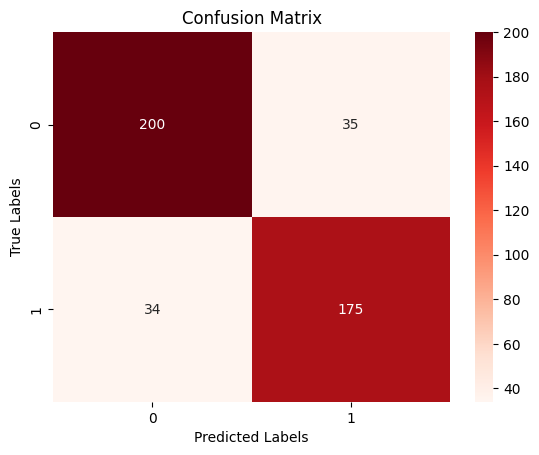

In [31]:
import seaborn as sns
conf_matrix = confusion_matrix(y_test, y_pred_rf)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

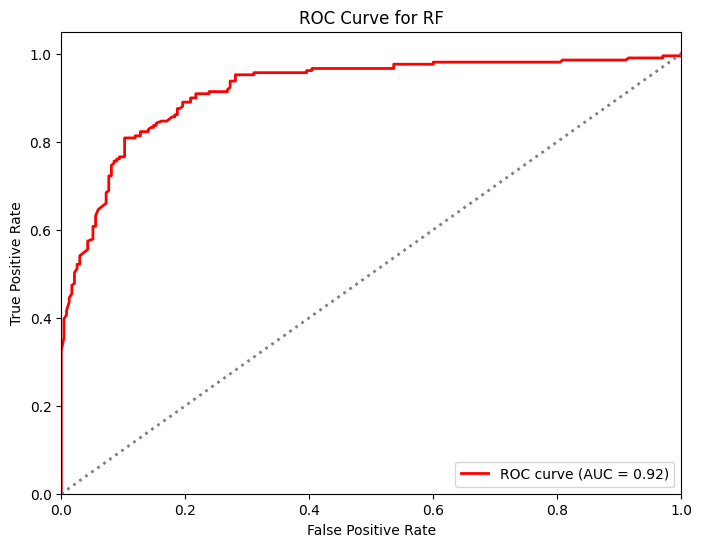

In [32]:
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_rf ) 
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='dotted', lw=2) 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for RF')
plt.legend(loc="lower right")
plt.show()

****Performance****

The model seems to perform well with an accuracy of 83.9% it achieved better results than of the logistic regression model.
Also, with an AUC of 0.91, we can almost say for certain, that the model can identify epilepsy's EEG readings from those that aren't associated with epilepsy. That is a big leap forward from the baseline model 

However, as can be seen below the random forest classifier uses all the features from the dataset. When thinking of future more scalable uses for classifier, predictions we may get biased results as this trained model probably suffers from overfitting. 

To verify the model's good fit for the epilepsy classification problem, I would attempt in trying to reduce the number of features while still preserving accuracy and AUC using feature importance analysis.

### Presentation of a single tree in the model

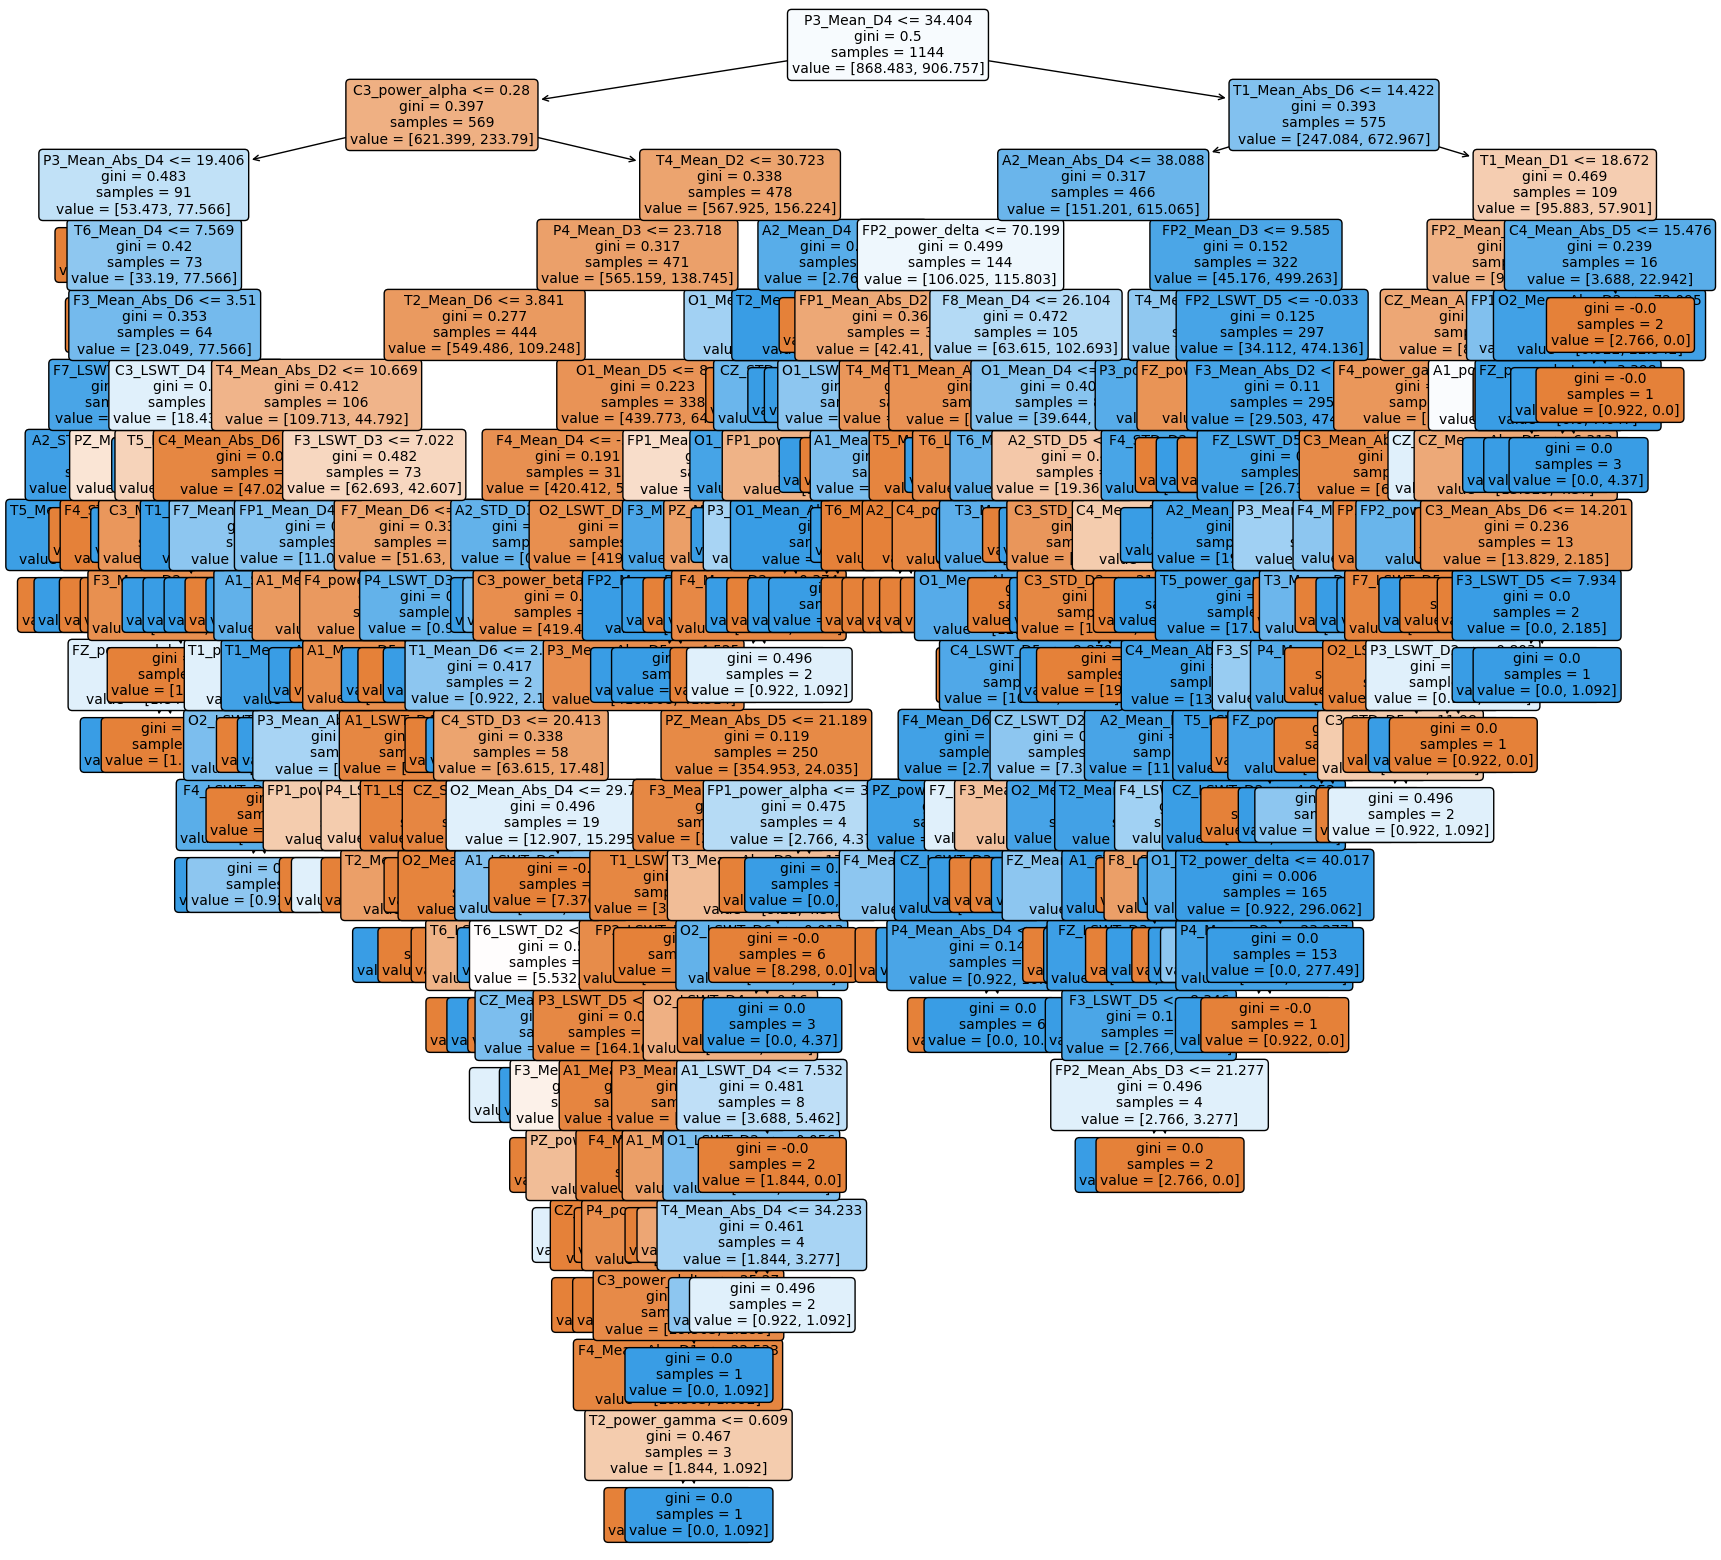

In [33]:
from sklearn.tree import export_graphviz
from sklearn.tree import plot_tree

# Select a single tree from the Random Forest
single_tree = rf_model.estimators_[0]  # First tree in the forest

# Plot the tree
plt.figure(figsize=(20,20))
plot_tree(single_tree, filled=True, feature_names=X.columns, rounded=True, fontsize=10)
plt.show()


Because using Cross Validation on the Baseline model showed consistancy in the results, I won't try apply CV again on the RF model but try another way to inspect ways of improvement

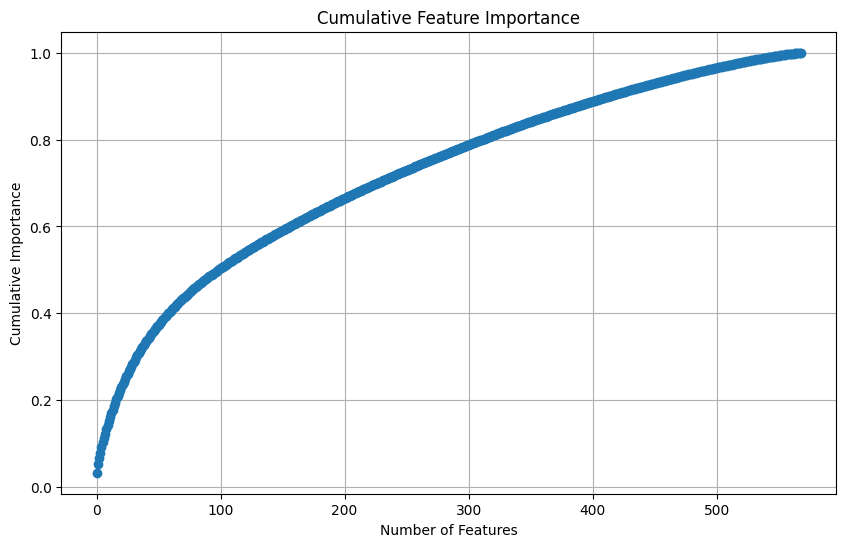

In [34]:
importances = rf_model.feature_importances_

indices = np.argsort(importances)[::-1]

cumulative_importance = np.cumsum(importances[indices])
# cumulative_importance = importances[indices]
plt.figure(figsize=(10, 6))
plt.plot(range(len(cumulative_importance)), cumulative_importance, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Feature Importance')
plt.grid(True)
plt.show()

***Feature Importance***

Here we can see that when cumulative summing the features' importance (in descending order, meaning the most important features are at the beginning), we achieve 50% cumulative importance at the top 100 features, that is about 1/6 of the entire features' columns. 

This indicates feature selection is critical when building a Decision Tree as many features don't contribute much to its learning and could only cause overfit. 

I decided to use cumulative feature importance analysis becasue of the following reasons: 
* The EEG dataset presents readings from electrodes that when viewed **overall** are supposed to indicate the existence of epilepsy, trying to view specific readings by themselves (and omit some) without looking at others simultaneously would be counterproductive since there is no single reading that indicates epilepsy without other meaningful ones. In order to wisely omit features (with the assumption of no previous medical knowledge) they should be evaluated together and not individually, and omitted in groups.
* Second, no single feature has significant importance (evaluated of more than 0.05 importance out of all importance) therefore looking at cumulative importance presents an effective tool for filtering data.



I will now set 5 thresholds of cumulative importance, for each I will derive the specific features that contributed to getting the cumulative importance of that threshold (Set from the most important ones, to the least important) and try to evaluate how the classifier performs with each number of features.

In [35]:
thresholds = [0.5,0.6,0.7,0.8,0.9]
X_reduced = []
for th in thresholds:
    num_features = np.argmax(cumulative_importance >= th) + 1
    print(f"Number of features to retain for {th*100}% cumulative importance: {num_features}")
    top_features = X.columns[indices][:num_features]
    X_reduced.append(X[top_features])
X_reduced_copy = X_reduced

Number of features to retain for 50.0% cumulative importance: 100
Number of features to retain for 60.0% cumulative importance: 157
Number of features to retain for 70.0% cumulative importance: 228
Number of features to retain for 80.0% cumulative importance: 312
Number of features to retain for 90.0% cumulative importance: 415


In [36]:
best_accuracy = 0
best_threshold = 0
best_model = None
best_report = ""
accuracies = []

In [37]:
for i, X in enumerate(X_reduced):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)
    
    rf_model = RandomForestClassifier(random_state=123)
    rf_model.fit(X_train, y_train)
    
    y_pred_rf = rf_model.predict(X_test)
    y_pred_prob_rf = rf_model.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred_rf)
    report = classification_report(y_test, y_pred_rf)
    accuracies.append(accuracy)
    print(f"\nRandom Forest with {thresholds[i]*100}% feature importance retained:")
    print(f"Accuracy: {accuracy}")
    print(report)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_threshold = thresholds[i]
        best_model = rf_model
        best_report = report
        y_pred_best = y_pred_rf
        y_pred_best_prob = y_pred_prob_rf
print(f"\nBest performing model retained {best_threshold*100}% feature importance with accuracy: {best_accuracy}")
print(best_report)


Random Forest with 50.0% feature importance retained:
Accuracy: 0.8483754512635379
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       298
           1       0.84      0.84      0.84       256

    accuracy                           0.85       554
   macro avg       0.85      0.85      0.85       554
weighted avg       0.85      0.85      0.85       554


Random Forest with 60.0% feature importance retained:
Accuracy: 0.8429602888086642
              precision    recall  f1-score   support

           0       0.86      0.85      0.85       298
           1       0.83      0.83      0.83       256

    accuracy                           0.84       554
   macro avg       0.84      0.84      0.84       554
weighted avg       0.84      0.84      0.84       554


Random Forest with 70.0% feature importance retained:
Accuracy: 0.8501805054151624
              precision    recall  f1-score   support

           0       0.86      0.86      

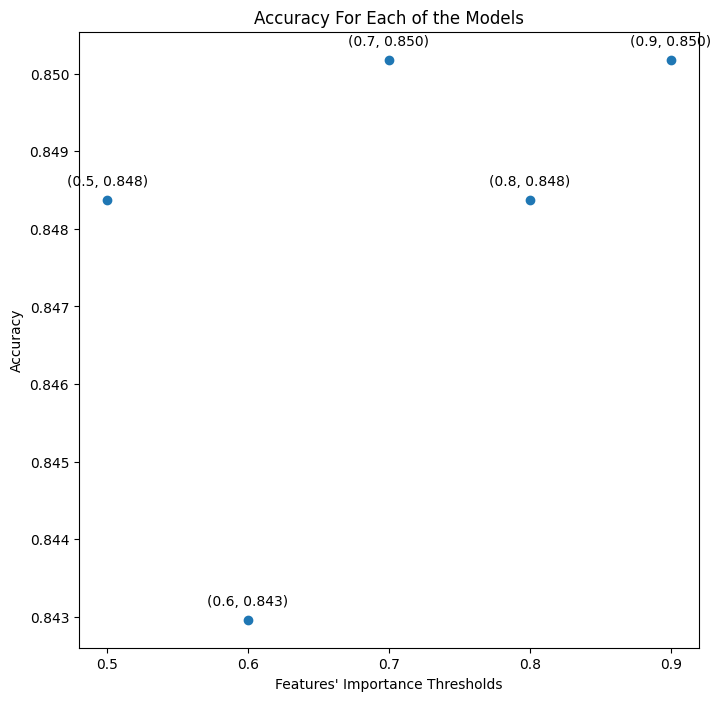

In [38]:
plt.figure(figsize = (8,8))
plt.scatter(thresholds, accuracies)
plt.xlabel("Features' Importance Thresholds")
plt.ylabel("Accuracy")
plt.title("Accuracy For Each of the Models")
plt.xticks(np.arange(0.5, 1, 0.1))
for i in range(len(thresholds)):
    plt.annotate(f"({thresholds[i]:.1f}, {accuracies[i]:.3f})", 
                 (thresholds[i], accuracies[i]),
                 textcoords="offset points", 
                 xytext=(0, 10),  
                 ha='center')
plt.show()

We can see how the accuracies vary, even if not by much, depending on the amount of features given to train the decision tree model. An optimum of 0.6 feature importances with 152 features fed to the model was achieved. 
This means we get an 86% accurate model (with other good metrics as could be seen below) with 22.8% out of the given columns. 

**Confusion Matrix and RUC for the 0.6 Threshold Random Forest Model**

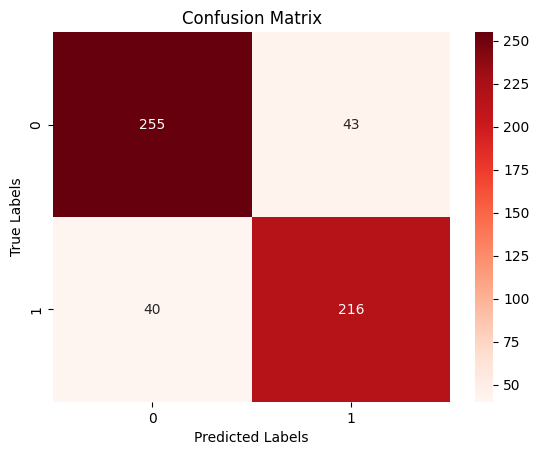

In [39]:
conf_matrix = confusion_matrix(y_test, y_pred_best)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

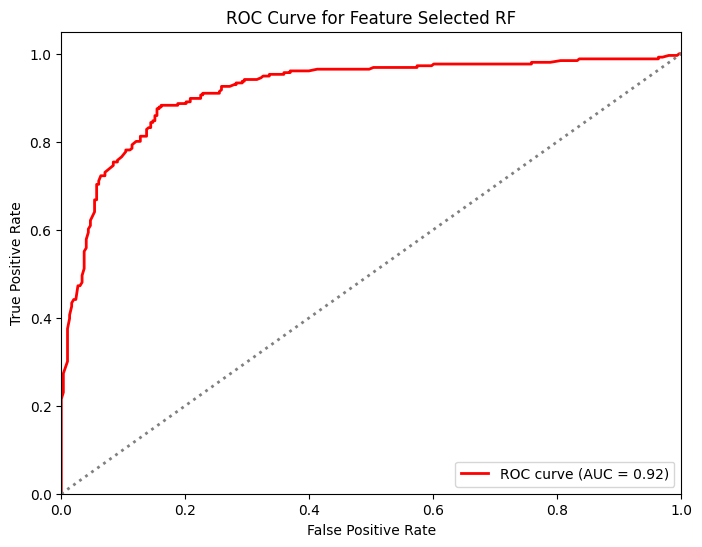

In [40]:
fpr, tpr, _ = roc_curve(y_test,y_pred_best_prob ) 
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='dotted', lw=2) 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Feature Selected RF')
plt.legend(loc="lower right")
plt.show()

*****Model Performance*****

From the beginning we could see Random Forest is a better fit for this dataset and the epilepsy classification problem as it achieved better performance metrics than the logistic regression did without any special intervention. 

However, by reducing the number of features used in training the model based on their initial importance I have achieved better results as well as mitigated the risk of creating an overfit model. Perhaps even in future use when trying to develop this model further it could cut costs as less computing power would be needed than with the initial training data.

Further steps in improving this model's performance should be random forest parameters optimization. This could be achieved by using grid search cross-validation.

However, I will now attempt to train a final model.

****XGBoost****

Since one of my main motives is consistancy and efficency, I am going to try and train this XGBoost model with the best dataset found on the random forest feature importance test.

In [41]:
from xgboost import XGBClassifier
X_train, X_test, y_train, y_test = train_test_split(X_reduced_copy[1], y, test_size=0.20, random_state=123)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=123)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
y_pred_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]
print(f"XGBoost Accuracy: {accuracy_score(y_test, y_pred_xgb)}")
print(classification_report(y_test, y_pred_xgb))

XGBoost Accuracy: 0.8574007220216606
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       298
           1       0.85      0.84      0.85       256

    accuracy                           0.86       554
   macro avg       0.86      0.86      0.86       554
weighted avg       0.86      0.86      0.86       554



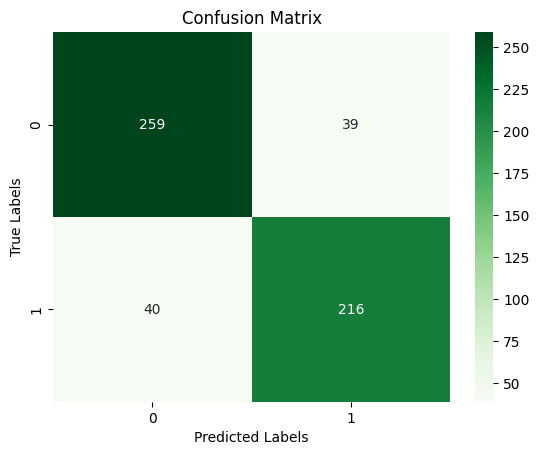

In [42]:
conf_matrix = confusion_matrix(y_test, y_pred_xgb)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

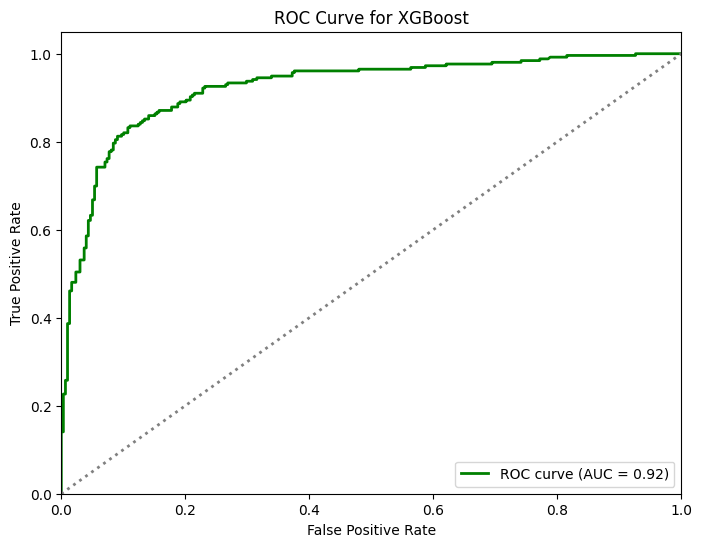

In [43]:
fpr, tpr, _ = roc_curve(y_test,y_pred_prob_xgb ) 
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='green', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='dotted', lw=2) 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost')
plt.legend(loc="lower right")
plt.show()

We can already see better performance than both prior models, as accuracy is a bit higher and AUC is high.
However, I will try to improve it.

XGBoost classifier has a default set of hyperparameters used when training it without specifying others: 

default_params = {
    'n_estimators': 100,
    'max_depth': 6,
    'learning_rate': 0.3,
    'colsample_bytree': 1,
    'gamma': 0,
    'subsample': 1,
    'reg_alpha': 0,
    'reg_lambda': 1,
}

I will try to create a different hyperparameters grid and use grid search cv to try and find an optimal parameters match that would achieve better results.

In [44]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [45]:
import xgboost as xgb
print(xgb.__version__)

2.0.3


In [46]:
from sklearn.model_selection import GridSearchCV


xgb_model = XGBClassifier(objective='binary:logistic',use_label_encoder=False, eval_metric='logloss', random_state=123)##,tree_method='hist', device='cuda')


param_grid = {
    'n_estimators': [100,200,300],
    'max_depth': [5,7,10],
    'learning_rate': [0.1, 0.2],
    'subsample': [0.9],
    'colsample_bytree': [0.5,0.9],
    'gamma': [0,0.1],
    'reg_alpha': [0,0.1],
    'reg_lambda': [0,1]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)

print("Best cross-validation accuracy: {:.2f}".format(grid_search.best_score_))

best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print(f"Test set accuracy: {test_accuracy:.2f}")

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best parameters found:  {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 300, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 0.9}
Best cross-validation accuracy: 0.86
Test set accuracy: 0.86


In [47]:
best_model.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=123, ...)

In [48]:
y_pred_xgb = best_model.predict(X_test)
y_pred_prob_xgb = best_model.predict_proba(X_test)[:, 1]
print(f"XGBoost Accuracy: {accuracy_score(y_test, y_pred_xgb)}")
print(classification_report(y_test, y_pred_xgb))

XGBoost Accuracy: 0.8628158844765343
              precision    recall  f1-score   support

           0       0.88      0.87      0.87       298
           1       0.85      0.86      0.85       256

    accuracy                           0.86       554
   macro avg       0.86      0.86      0.86       554
weighted avg       0.86      0.86      0.86       554



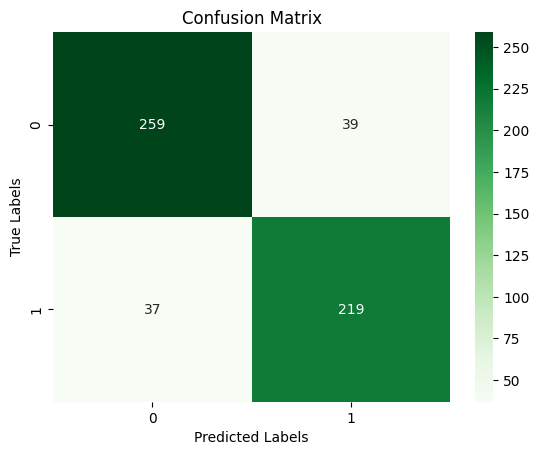

In [49]:
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  

conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


<function matplotlib.pyplot.show(close=None, block=None)>

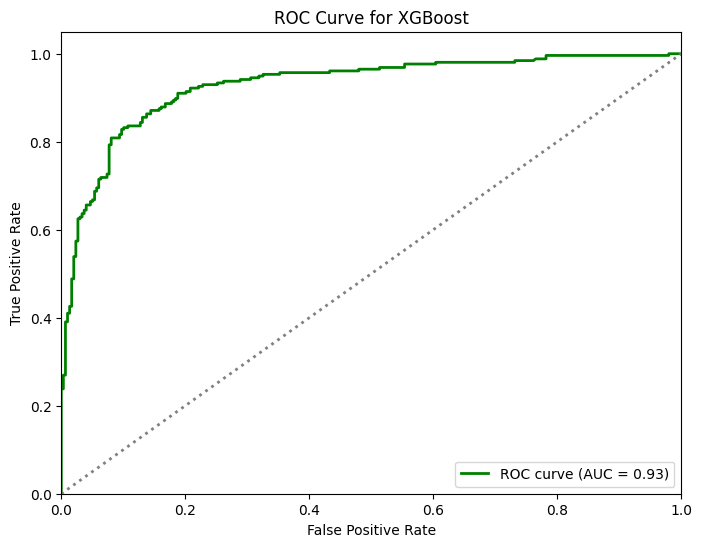

In [50]:
fpr, tpr, _ = roc_curve(y_test,y_pred_proba ) 
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='green', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='dotted', lw=2) 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost')
plt.legend(loc="lower right")
plt.show


***Model Performance***

XGBoost achieved excellent results on the epilepsy classification problem with a good accuracy percentage at 87% and a high AUC. 

It is important to point out that while both "basic" xgboost and grid search xgboost resulted in the same accuracy, AUC was slightly improved when trying to tune the hyperparameters of the xgboost model. 

Higher AUC means the letter model had a better ability to distinguish false predictions from correct ones.
This presents future opportunities as even better results could be achieved with higher computational power to further fine-tune the hyperparameters optimization, and also with data on a larger scale better accuracies could be achieved.

# save Model

In [52]:
from joblib import dump
import sklearn, sys
import numpy as np

# Save model + feature names + versions + any metadata you want
artifact = {
    "model": best_model,
    "features": list(X_train.columns),      # preserves exact column order
    "classes_": getattr(best_model, "classes_", None),
    "meta": {
        "python": sys.version,
        "sklearn": sklearn.__version__,
        "threshold_used": None,             # fill if you use a custom decision threshold
        "notes": "Trained on 80/20 split, random_state=123"
    }
}

dump(artifact, "model_bundle.joblib")
print("Saved -> model_bundle.joblib")


Saved -> model_bundle.joblib


In [53]:
import joblib
import json
from datetime import datetime

# Suppose this is the best RF you decided to keep:
best_rf_model = rf_model  # or your chosen/best one
rf_feature_names = list(X_train.columns)

joblib.dump(best_rf_model, "rf_model.joblib")
with open("rf_features.json", "w", encoding="utf-8") as f:
    json.dump({"features": rf_feature_names, "saved_at": datetime.now().isoformat()}, f)

print("Saved rf_model.joblib and rf_features.json")


Saved rf_model.joblib and rf_features.json
